## 1. Setup and Installation

In [1]:
# Install required packages
!pip install datasets transformers torch scikit-learn pandas numpy matplotlib seaborn wordcloud nltk -q

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings, re
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

# Deep Learning libraries
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Data Loading and Exploration

In [3]:
# Load the dataset
df = pd.read_csv('Mental Health Text Dataset for Emotion and Condition Classification.csv')
df.head(10)

,text,status
0,"""My mind is a never-ending cycle of worry, and...",anxiety
1,Despite the sun shining and birds singing outs...,bipolar
2,"I'm drowning in responsibilities, each one dem...",stress
3,"""My emotions shift like the wind, leaving me u...",personality disorder
4,"I'm trapped in a whirlwind of thoughts, unable...",anxiety
5,"Despite the sun shining outside, the depths of...",bipolar
6,"""I'm drowning in tasks and responsibilities, e...",stress
7,"""I want to be true to myself, but who am I, re...",personality disorder
8,"""Every moment is a battlefield in my mind. The...",anxiety
9,"Example: This morning, I felt a spark of creat...",bipolar


### 2.1 Dataset Statistics

In [4]:
# Basic statistics
print("DATASET STATISTICS")

print(f"\n Total samples: {len(df):,}")
print(f" Number of classes: {df['status'].nunique()}")
# Filter out NaN values before sorting unique classes to avoid TypeError
print(f" Classes: {sorted(df['status'].dropna().unique())}")

# Check for missing values
print(f"\n Missing values:")
print(df.isnull().sum())

DATASET STATISTICS

 Total samples: 103,488
 Number of classes: 7
 Classes: ['anxiety', 'bipolar', 'depression', 'normal', 'personality disorder', 'stress', 'suicidal']

 Missing values:
text      0
status    0
dtype: int64


### 2.2 Class Distribution


 Class Distribution:
  anxiety                  : 17,620 samples (17.03%)
  normal                   : 16,068 samples (15.53%)
  depression               : 15,901 samples (15.37%)
  stress                   : 15,230 samples (14.72%)
  personality disorder     : 13,915 samples (13.45%)
  bipolar                  : 13,708 samples (13.25%)
  suicidal                 : 11,046 samples (10.67%)


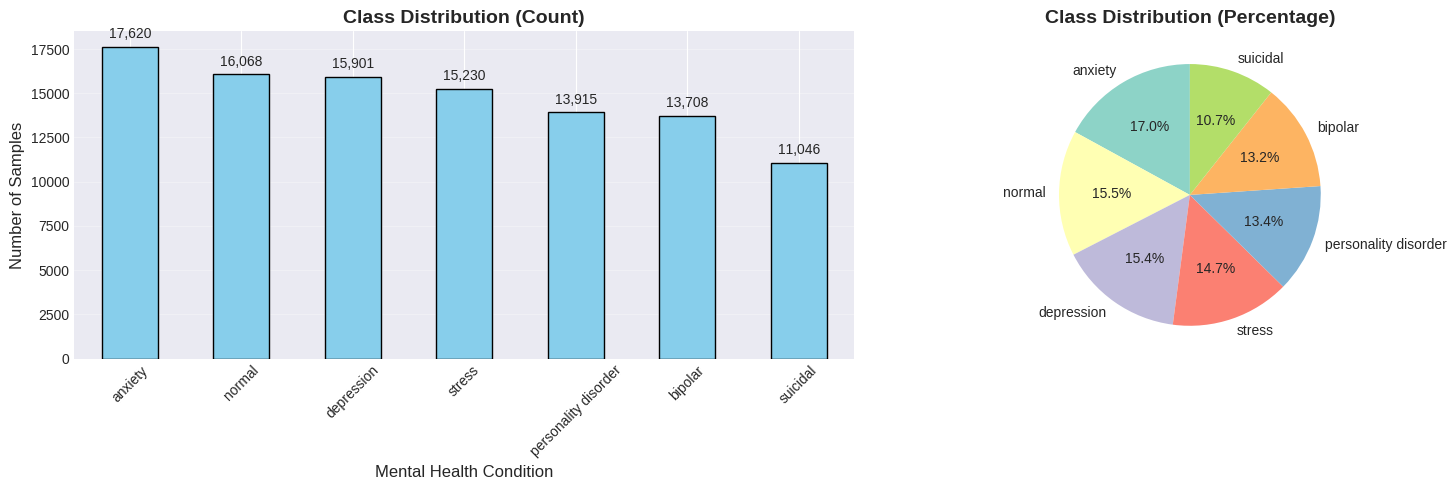


 Observation: Dataset is relatively balanced with classes ranging from 10.67% to 17.03%


In [5]:
# Class distribution
class_counts = df['status'].value_counts()
class_percentages = (class_counts / len(df) * 100).round(2)

print("\n Class Distribution:")
for status, count in class_counts.items():
    percentage = class_percentages[status]
    print(f"  {status:25s}: {count:6,} samples ({percentage:5.2f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mental Health Condition', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontsize=10)

# Pie chart
colors = plt.cm.Set3(range(len(class_counts)))
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 10})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Observation: Dataset is relatively balanced with classes ranging from 10.67% to 17.03%")

### 2.3 Word Clouds

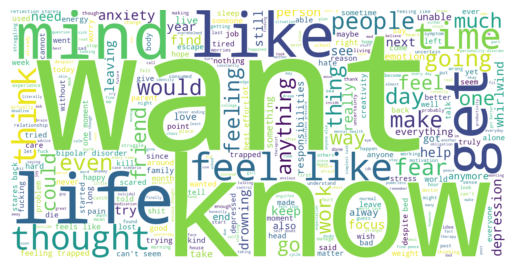

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Combine all text across statuses
all_text = " ".join(df['text'].tolist())

# Generate one word cloud
wc = WordCloud(width=2000, height=1000, background_color='white',
               stopwords=stop_words, max_words=350,
               colormap='viridis').generate(all_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2.4 Most Common Words by Class

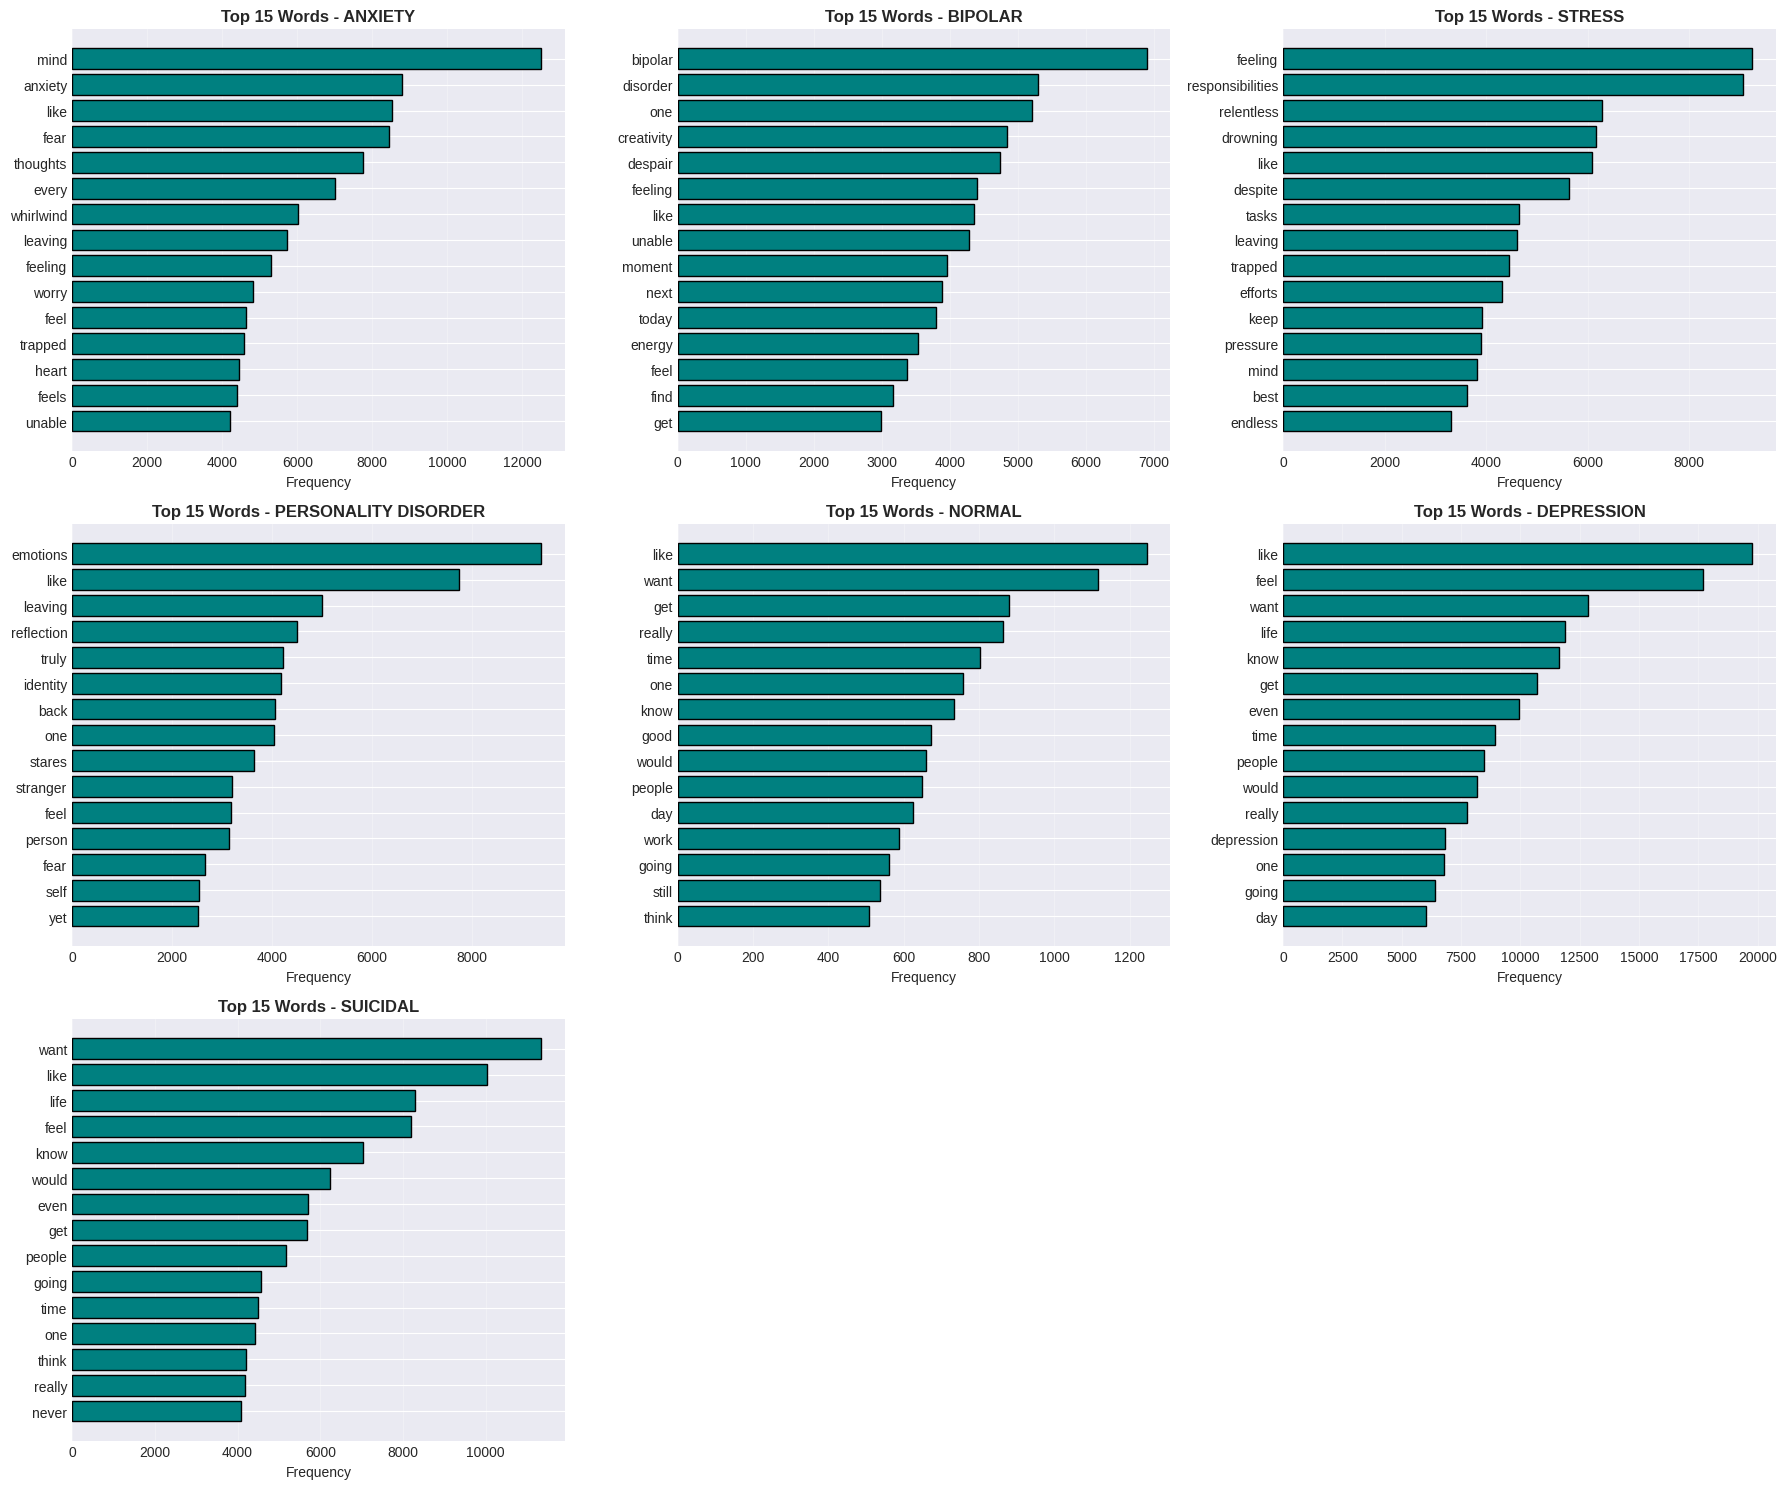

In [7]:
# Function to get top words for a class
import math

def get_top_words(texts, n=15):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in texts:
        # Ensure text is a string before lowercasing and tokenizing
        if isinstance(text, str):
            tokens = word_tokenize(text.lower())
            words.extend([w for w in tokens if w.isalpha() and w not in stop_words and len(w) > 2])
    return Counter(words).most_common(n)

# Define n_classes, n_rows, n_cols, and classes
n_classes = df['status'].nunique()
classes = df['status'].dropna().unique() # Filter out NaN values from classes
n_cols = 3  # Number of columns for subplots
n_rows = math.ceil(n_classes / n_cols)

# Visualize top words for each class
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, status in enumerate(classes):
    texts = df[df['status'] == status]['text'].values
    top_words = get_top_words(texts, n=15)

    # Check if top_words is not empty before unpacking
    if top_words:
        words, counts = zip(*top_words)
        axes[idx].barh(words, counts, color='teal', edgecolor='black')
        axes[idx].set_title(f'Top 15 Words - {status.upper()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Frequency', fontsize=10)
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    else:
        axes[idx].set_title(f'No words for - {status.upper()}', fontsize=12, fontweight='bold')

# Hide extra subplots
for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [8]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)
print(df.iloc[0]['text'][:200])
print("\n[PROCESSED]")
print(df.iloc[0]['processed_text'][:200])

"My mind is a never-ending cycle of worry, and even the simplest tasks feel insurmountable."

"I'm consumed by fear and doubt, and every decision feels like a minefield waiting to explode."

"Anxiety 

[PROCESSED]
mind neverending cycle worry even simplest task feel insurmountable consumed fear doubt every decision feel like minefield waiting explode anxiety grip powerless break free relentless hold thought rac


### 3.1 Label Encoding

In [9]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['status'])

# Display encoding
print("Label Encoding:")
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
for status, label in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {label}: {status}")

# Store for later use
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"\n Number of classes: {num_classes}")

Label Encoding:
  0: anxiety
  1: bipolar
  2: depression
  3: normal
  4: personality disorder
  5: stress
  6: suicidal

 Number of classes: 7


### 3.2 Train-Test Split

In [10]:
# Remove rows with NaN in the 'status' column before splitting
df.dropna(subset=['status'], inplace=True)

# Update class_names after dropping NaN values
# This ensures class_names only contains the actual mental health conditions.
class_names = df['status'].dropna().unique()

# Split data into train and test sets
X = df['processed_text']
y = df['label']
X_raw = df['text']  # Keep raw text for BERT

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X_train_raw, X_test_raw = train_test_split( X_raw, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

## 4. Model 1: Logistic Regression

### 4.1 Feature Extraction with TF-IDF

In [11]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features created!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")
print(f" Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF features created!
Feature matrix shape: (82790, 5000)
 Number of features: 5000


### 4.2 Training Logistic Regression

In [27]:
# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression()

### 4.3 Logistic Regression Evaluation

In [28]:
# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_lr_proba = lr_model.predict_proba(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

# Detailed classification report
print("DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_lr, target_names=class_names, digits=4))

DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

             anxiety     0.9356    0.9407    0.9382      3524
             bipolar     0.9817    0.9373    0.9590      2742
              stress     0.6791    0.7167    0.6974      3180
personality disorder     0.8411    0.9437    0.8894      3214
              normal     0.9859    0.9536    0.9695      2783
          depression     0.9524    0.8943    0.9225      3046
            suicidal     0.6639    0.6080    0.6347      2209

            accuracy                         0.8657     20698
           macro avg     0.8628    0.8563    0.8587     20698
        weighted avg     0.8679    0.8657    0.8659     20698



## 5. Model 2: Random Forest

### 5.1 Training Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,       # limit depth to prevent huge trees
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

### 5.2 Random Forest Evaluation

In [32]:
# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_rf_proba = rf_model.predict_proba(X_test_tfidf)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("RANDOM FOREST - PERFORMANCE METRICS")
print(f"\n Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

# Detailed classification report
print("DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_rf, target_names=class_names, digits=4))

RANDOM FOREST - PERFORMANCE METRICS

 Accuracy:  0.7805 (78.05%)
Precision: 0.8226
Recall:    0.7805
F1-Score:  0.7695
DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

             anxiety     0.9208    0.8351    0.8759      3524
             bipolar     0.9905    0.8778    0.9308      2742
              stress     0.5484    0.7387    0.6295      3180
personality disorder     0.5927    0.9689    0.7355      3214
              normal     0.9817    0.9066    0.9426      2783
          depression     0.9872    0.8073    0.8882      3046
            suicidal     0.7595    0.1630    0.2684      2209

            accuracy                         0.7805     20698
           macro avg     0.8258    0.7568    0.7530     20698
        weighted avg     0.8226    0.7805    0.7695     20698



### 5.3 Feature Importance

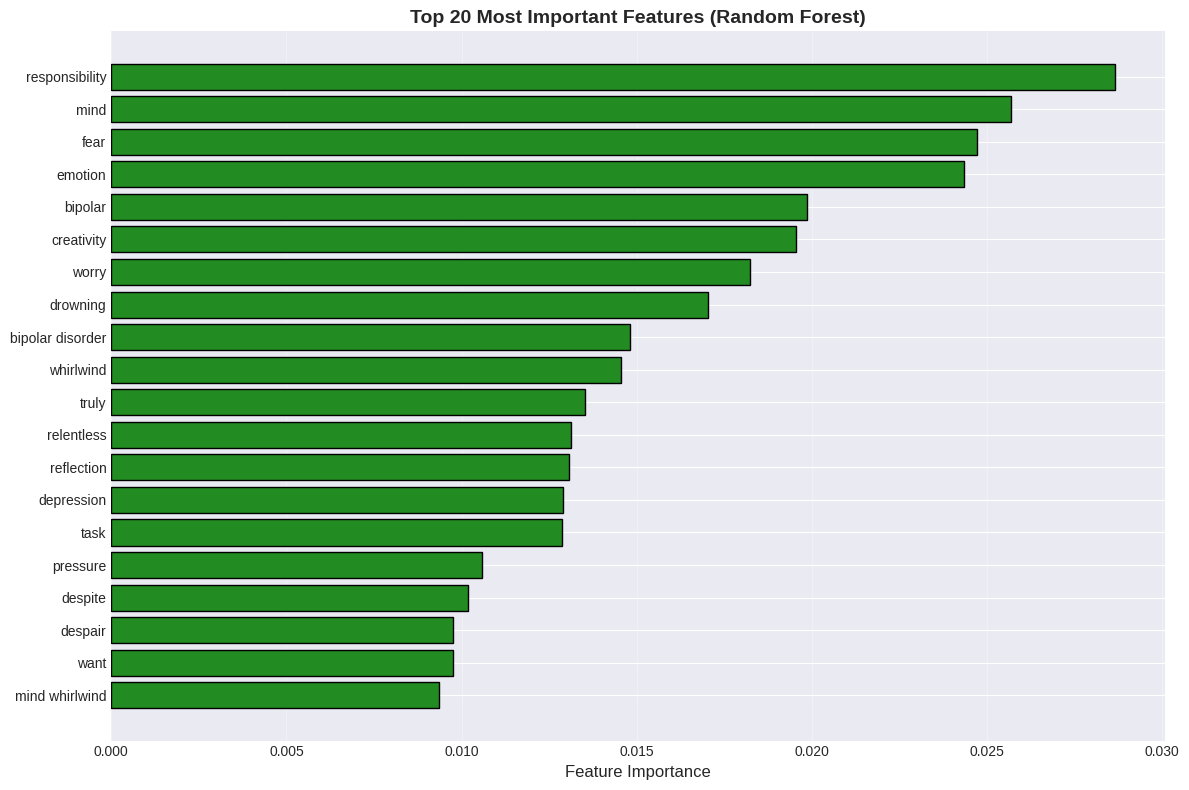

In [34]:
# Get feature importance
feature_importance = rf_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(top_features, top_importance, color='forestgreen', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Model 3: Naive bayes

### 6.1 Prepare Data for Naive

In [35]:
# Import Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes model
print("Training Naive Bayes model...")

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Naive Bayes model trained successfully!")

Training Naive Bayes model...
Naive Bayes model trained successfully!


In [36]:
# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)
y_pred_nb_proba = nb_model.predict_proba(X_test_tfidf)

# Calculate metrics
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb, average='weighted')
nb_recall = recall_score(y_test, y_pred_nb, average='weighted')
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')

print("NAIVE BAYES - PERFORMANCE METRICS")
print(f"\nAccuracy:  {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-Score:  {nb_f1:.4f}")

# Detailed classification report
print("DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_nb, target_names=class_names, digits=4))

NAIVE BAYES - PERFORMANCE METRICS

Accuracy:  0.7806 (78.06%)
Precision: 0.8178
Recall:    0.7806
F1-Score:  0.7896
DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

             anxiety     0.8674    0.8110    0.8382      3524
             bipolar     0.9797    0.8253    0.8959      2742
              stress     0.4904    0.8028    0.6089      3180
personality disorder     0.7429    0.7184    0.7305      3214
              normal     0.9847    0.9260    0.9544      2783
          depression     0.9799    0.8145    0.8896      3046
            suicidal     0.6840    0.5048    0.5809      2209

            accuracy                         0.7806     20698
           macro avg     0.8184    0.7718    0.7855     20698
        weighted avg     0.8178    0.7806    0.7896     20698



## 7. Model Comparison

### 7.1 Performance Comparison Table

In [39]:
# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes'],
    'Accuracy': [lr_accuracy, rf_accuracy, nb_accuracy],
    'Precision': [lr_precision, rf_precision, nb_precision],
    'Recall': [lr_recall, rf_recall, nb_recall],
    'F1-Score': [lr_f1, rf_f1, nb_f1]
}

comparison_df = pd.DataFrame(comparison_data)
print("MODEL COMPARISON - OVERALL PERFORMANCE")
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.iloc[best_model_idx]['Model']
print(f"\n Best model based on F1-Score: {best_model}")

MODEL COMPARISON - OVERALL PERFORMANCE
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.865688   0.867865 0.865688  0.865870
      Random Forest  0.780510   0.822628 0.780510  0.769454
        Naive Bayes  0.780559   0.817771 0.780559  0.789613

 Best model based on F1-Score: Logistic Regression


### 7.2 Performance Visualization

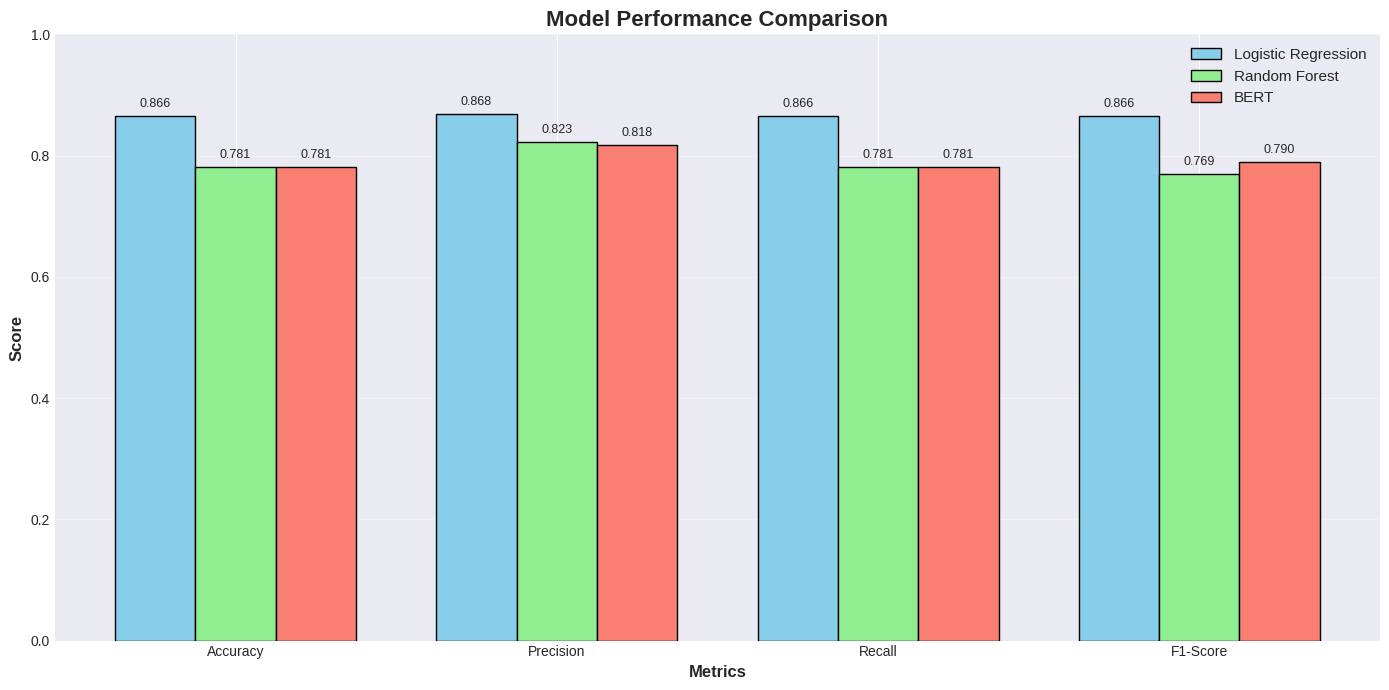

In [40]:
# Visualize model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

bars1 = ax.bar(x - width, comparison_df.iloc[0][1:], width, label='Logistic Regression', color='skyblue', edgecolor='black')
bars2 = ax.bar(x, comparison_df.iloc[1][1:], width, label='Random Forest', color='lightgreen', edgecolor='black')
bars3 = ax.bar(x + width, comparison_df.iloc[2][1:], width, label='BERT', color='salmon', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()

### 7.3 Confusion Matrices

Confusion Matrices:



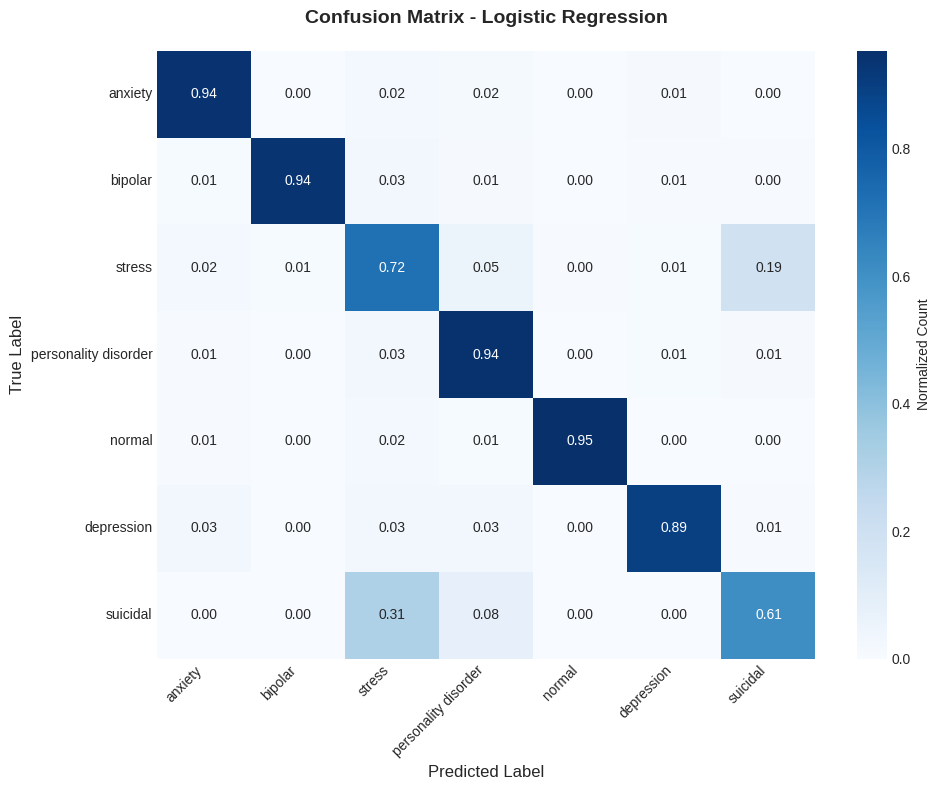

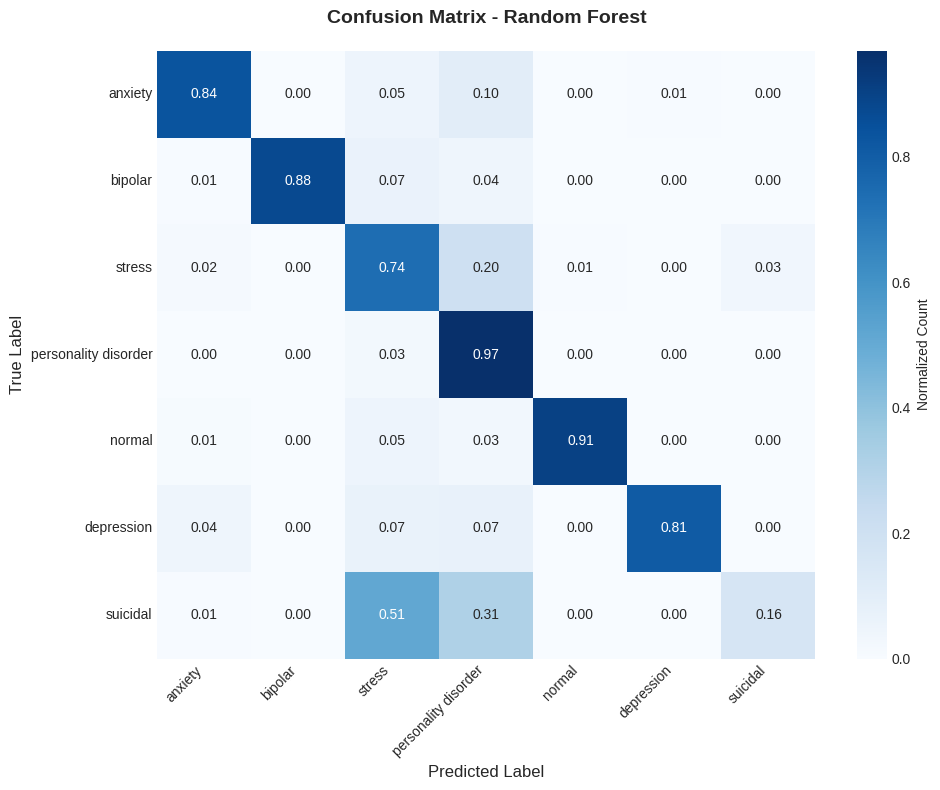

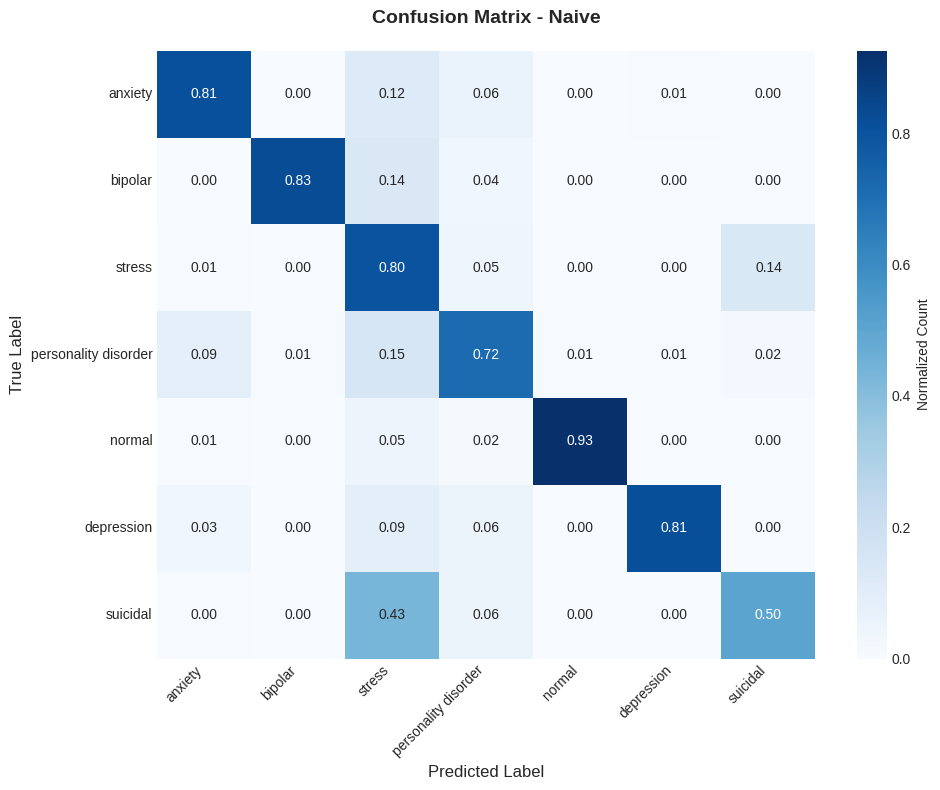

In [45]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
print("Confusion Matrices:\n")
plot_confusion_matrix(y_test, y_pred_lr, 'Confusion Matrix - Logistic Regression', class_names)
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix - Random Forest', class_names)
plot_confusion_matrix(y_test, y_pred_nb, 'Confusion Matrix - Naive', class_names)

### 7.5 ROC Curves

 ROC Curves:



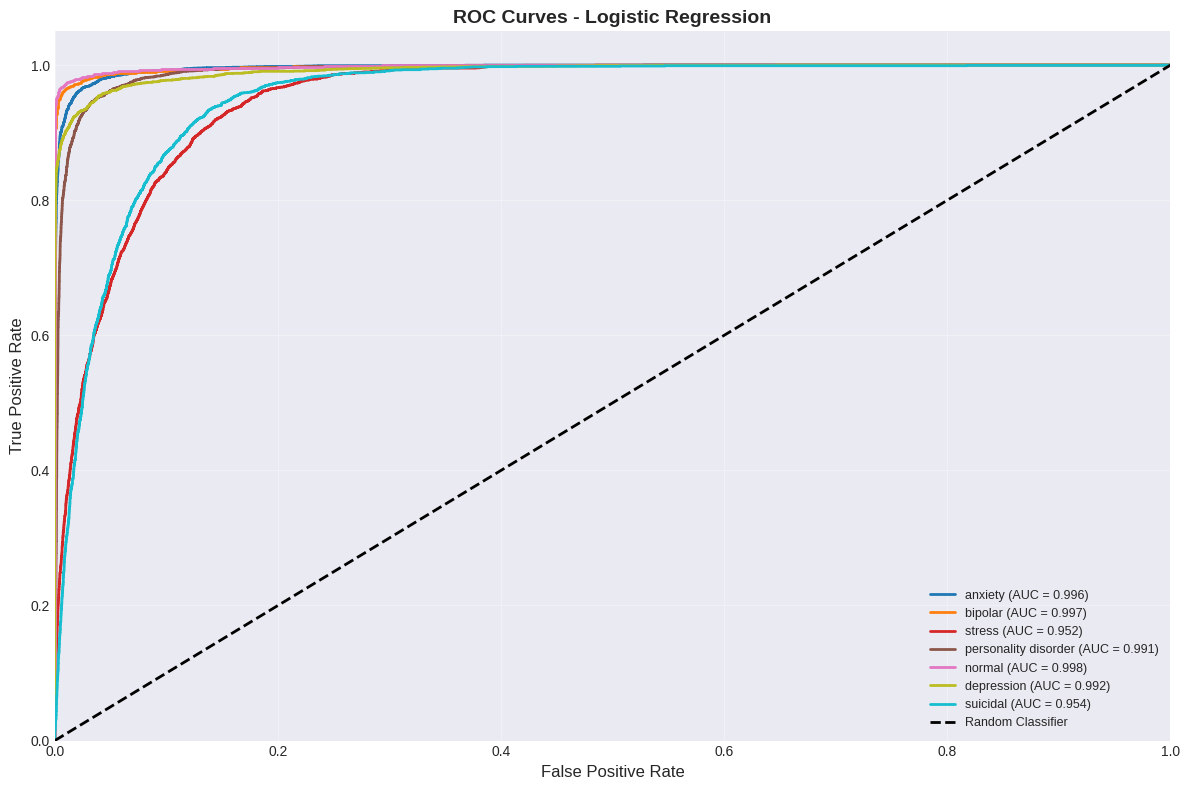


 Logistic Regression - Macro-average AUC: 0.9830


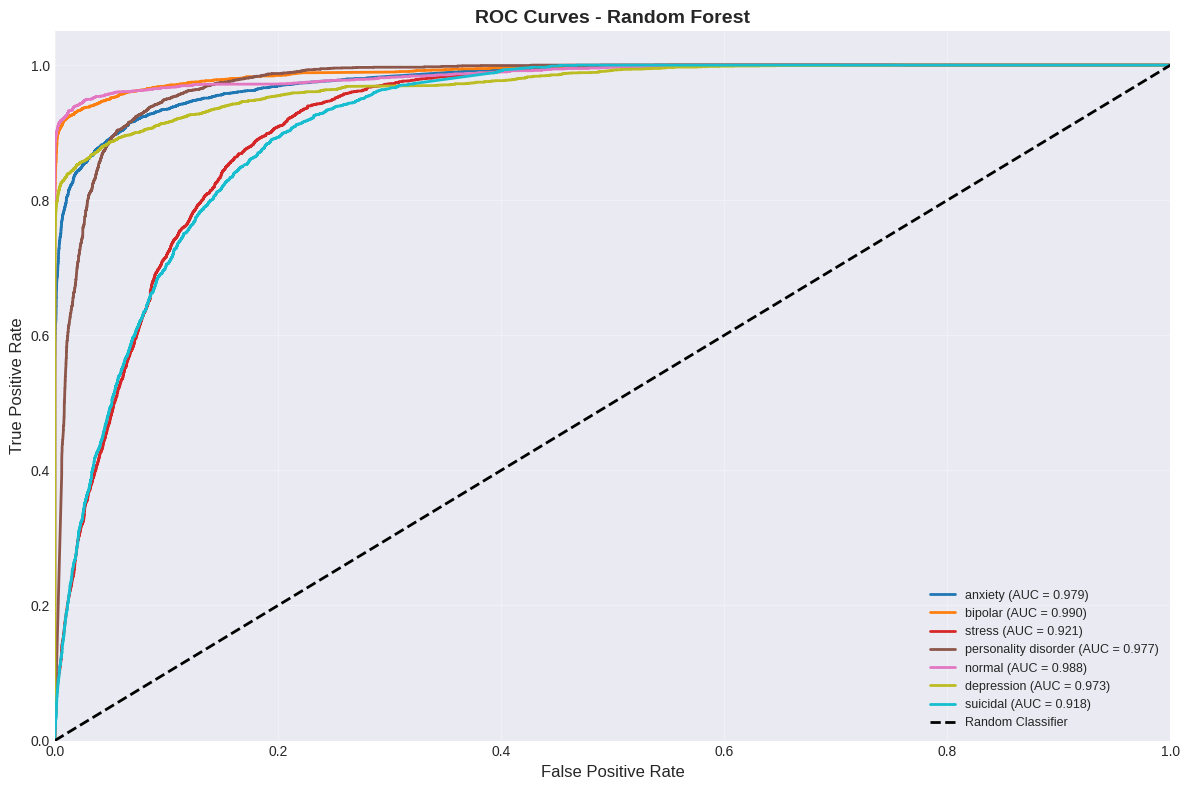


 Random Forest - Macro-average AUC: 0.9638


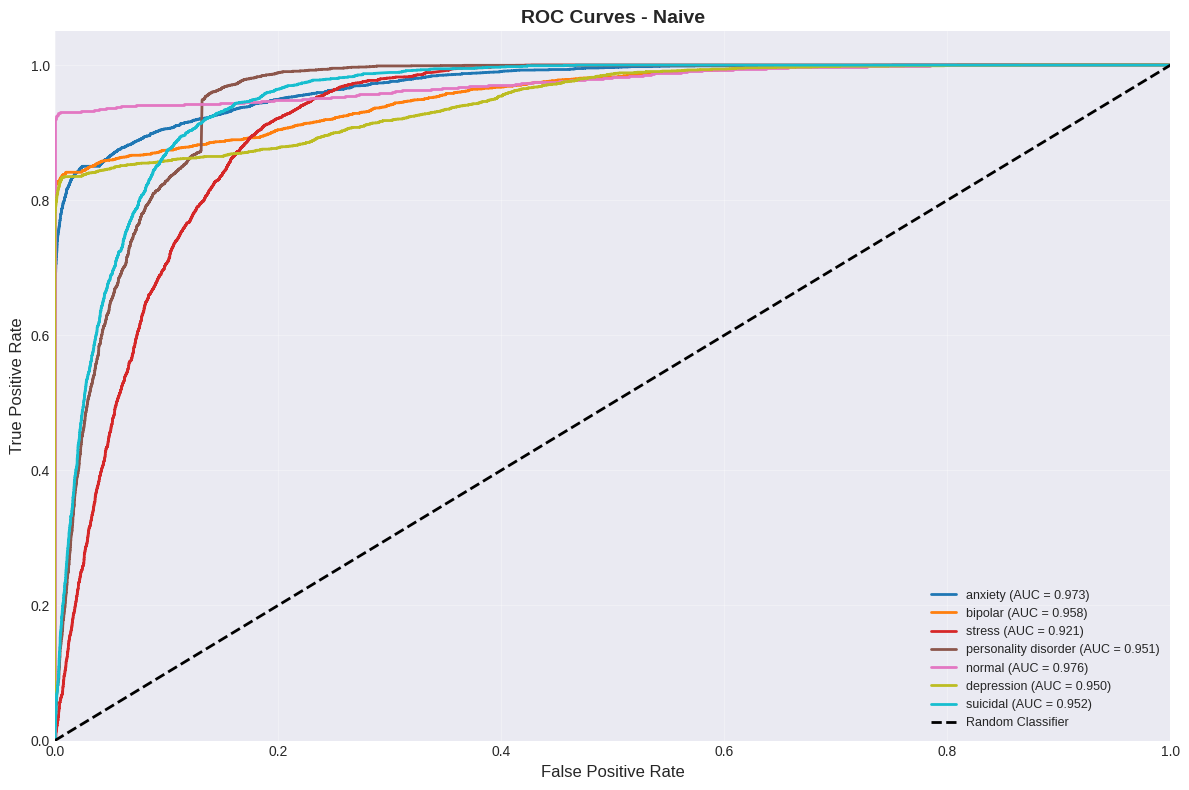


 Naive - Macro-average AUC: 0.9543
MACRO-AVERAGE AUC COMPARISON
Logistic Regression: 0.9830
Random Forest:       0.9638
Naive:                0.9543


In [47]:
# Function to plot ROC curves for multi-class classification
def plot_multiclass_roc(y_true, y_pred_proba, class_names, title, model_name):
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])

    # Plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(class_names)))

    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate and print macro-average AUC
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"\n {model_name} - Macro-average AUC: {macro_auc:.4f}")
    return macro_auc

# Plot ROC curves for all models
print(" ROC Curves:\n")
lr_auc = plot_multiclass_roc(y_test, y_pred_lr_proba, class_names,
                             'ROC Curves - Logistic Regression', 'Logistic Regression')
rf_auc = plot_multiclass_roc(y_test, y_pred_rf_proba, class_names,
                             'ROC Curves - Random Forest', 'Random Forest')
nb_auc = plot_multiclass_roc(y_test, y_pred_nb_proba, class_names,
                               'ROC Curves - Naive', 'Naive')

# Summary
print("MACRO-AVERAGE AUC COMPARISON")
print(f"Logistic Regression: {lr_auc:.4f}")
print(f"Random Forest:       {rf_auc:.4f}")
print(f"Naive:                {nb_auc:.4f}")

## 8. Sample Predictions

In [56]:
# Function to predict with all models
def predict_all_models(text):
    print("INPUT TEXT:")
    print(text)

    print("PREDICTIONS:")

    # Preprocess for traditional ML models
    processed_text = preprocess_text(text)
    text_tfidf = tfidf_vectorizer.transform([processed_text])

    # Logistic Regression prediction
    lr_pred = lr_model.predict(text_tfidf)[0]
    lr_proba = lr_model.predict_proba(text_tfidf)[0]
    lr_confidence = lr_proba[lr_pred]
    print(f"\n Logistic Regression:")
    print(f"   Predicted: {class_names[lr_pred]}")
    print(f"   Confidence: {lr_confidence:.2%}")

    # Random Forest prediction
    rf_pred = rf_model.predict(text_tfidf)[0]
    rf_proba = rf_model.predict_proba(text_tfidf)[0]
    rf_confidence = rf_proba[rf_pred]
    print(f"\n Random Forest:")
    print(f"   Predicted: {class_names[rf_pred]}")
    print(f"   Confidence: {rf_confidence:.2%}")

    nb_pred = nb_model.predict(text_tfidf)[0]
    nb_proba = nb_model.predict_proba(text_tfidf)[0]
    nb_confidence = nb_proba[nb_pred]
    print(f"\nNaive Bayes:")
    print(f"   Predicted: {class_names[nb_pred]}")
    print(f"   Confidence: {nb_confidence:.2%}")

# Test with sample texts
sample_texts = [
    "I feel overwhelmed with constant worry and fear about everything in my life.",
    "I'm experiencing extreme mood swings from very high energy to deep sadness.",
    "I want to die.",
]

for i, text in enumerate(sample_texts, 1):
    print(f"SAMPLE {i}")
    predict_all_models(text)
    print("\n")

SAMPLE 1
INPUT TEXT:
I feel overwhelmed with constant worry and fear about everything in my life.
PREDICTIONS:

 Logistic Regression:
   Predicted: anxiety
   Confidence: 87.01%

 Random Forest:
   Predicted: anxiety
   Confidence: 51.47%

Naive Bayes:
   Predicted: anxiety
   Confidence: 93.12%


SAMPLE 2
INPUT TEXT:
I'm experiencing extreme mood swings from very high energy to deep sadness.
PREDICTIONS:

 Logistic Regression:
   Predicted: bipolar
   Confidence: 80.37%

 Random Forest:
   Predicted: personality disorder
   Confidence: 29.48%

Naive Bayes:
   Predicted: bipolar
   Confidence: 99.56%


SAMPLE 3
INPUT TEXT:
I want to die.
PREDICTIONS:

 Logistic Regression:
   Predicted: suicidal
   Confidence: 89.75%

 Random Forest:
   Predicted: personality disorder
   Confidence: 30.69%

Naive Bayes:
   Predicted: suicidal
   Confidence: 75.27%


